In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import os
import ipywidgets as widgets

import pyclesperanto_prototype as cle
from scipy import ndimage
from skimage.morphology import binary_closing, binary_opening, disk
from aicsimageio import AICSImage
from apoc import ObjectSegmenter
import napari

In [3]:
from image_analysis.read_files import get_paths, change_paths
from image_analysis.preprocess import plot
from image_analysis.preprocess import mask
from image_analysis.fit import roi

# Preproccesing

## <span style='color:Red'> [Manual input -> inputs.py]  </span> file path, channels, parameters

In [4]:
from inputs import *

### <span style='color:Red'> [Manual input]  </span>  Image folder

In [5]:
image_folder = r'/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/'

In [6]:
img_paths = get_paths(image_folder, exclude='.lif_', suffix='.lif')
img_paths = change_paths(img_paths, '', 'lifext')
img_paths = change_paths(img_paths, '', 'bleached')

In [7]:
i = 0
for path in img_paths:
    print(i, path)
    i += 1

0 /home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fr_20221028.lif
1 /home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/hcr11_edu488_f546_s647_d750_dapi_easy_5cmbl_8d_20221103.lif
2 /home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/hcr11_edu488_f546_s647_d750_dapi_easy_5cmbl_10d_20221102.lif
3 /home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.lif
4 /home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/hcr11_edu480_f546_s647_d750_dapi_easy_lb27_fr_

### <span style='color:Red'> [Manual input]  </span>  choose file

In [8]:
i = 3
img_path = img_paths[i]
print(img_path)

/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.lif


In [9]:
image_folder_tif = os.path.join(
    os.path.dirname(img_path), 
    'tif'
)

In [10]:
sample = img_path.split('_')[-3] + '_' + img_path.split('_')[-2]
sample

'lb28_fl'

In [11]:
img_paths = get_paths(image_folder_tif, suffix='tif')
img_paths = change_paths(img_paths, include=sample)
img_paths

['/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c5_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c1_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c4_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c7_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c3_hcr11_

In [12]:
img_paths = sorted(
    img_paths,
    key = lambda c: c.split('tif/c')[1].split('_')[0]
)

In [13]:
img_paths

['/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c1_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c2_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c3_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c4_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif',
 '/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c5_hcr11_

### Load images

In [14]:
#Voxel size: 0.6764x0.6764x2.9983 micron^3

pixel_size_x, pixel_size_y, pixel_size_z = 0.6764, 0.6764, 2.9983

print('physical pixels sizes x, y, z:   ', pixel_size_x, pixel_size_y, pixel_size_z)

pixel_size_z = downsample * pixel_size_z * 1e-6
pixel_size_y = downsample * pixel_size_y * 1e-6
pixel_size_x = downsample * pixel_size_x * 1e-6

pixel_size = np.array([pixel_size_z, -pixel_size_y, pixel_size_x]) # (ez, ey, ex) corresponds k, i, j table indexes

print('downsamples pixels sizes x, y, z:', pixel_size_x, pixel_size_y, pixel_size_z)

physical pixels sizes x, y, z:    0.6764 0.6764 2.9983
downsamples pixels sizes x, y, z: 1.3528e-06 1.3528e-06 5.9965999999999995e-06


In [15]:
import tifffile

In [16]:
img = []
for path in img_paths:
    print(path)
    i = tifffile.imread(path)
    #print(i.shape)
    img.append(i[::downsample, ::downsample, ::downsample])
img = np.array(img).astype( np.uint16 )

/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c1_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif
/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c2_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif
/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c3_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif
/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c4_hcr11_edu480_f546_s647_d750_dapi_easy_lb28_fl_20221028.tif
/home/natalia/Documents/github_image_analysis/experimental_data/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_edu_488_hoechst/hcr11_stellaris/tif/c5_hcr11_edu480_f546_s647_d

In [17]:
img.shape

(7, 40, 512, 512)

In [18]:
from inputs import channels

In [19]:
channels = list(channels.keys())

In [20]:
channels

['dapi', 'fgf', 'dusp', 'edu', 'shh', 'autofluor', 'bright']

In [21]:
img = dict(zip(channels, img))

In [22]:
del img['bright']
del img['autofluor']
del img['edu']
del img['dapi']

### Isotropic

In [23]:
print('make isotropic')

pixel_size_aim = pixel_size_aim_user_def

scaling_x= pixel_size_x/pixel_size_aim
scaling_y= pixel_size_y/pixel_size_aim
scaling_z= pixel_size_z/pixel_size_aim

print('original pixel sizes x y z', pixel_size_x, pixel_size_y, pixel_size_z )
print('scaling facttors x y z', scaling_x, scaling_y, scaling_z)

make isotropic
original pixel sizes x y z 1.3528e-06 1.3528e-06 5.9965999999999995e-06
scaling facttors x y z 0.6764 0.6764 2.9983


In [24]:
for key in img:
    img[key] = cle.scale(img[key], None, scaling_x, scaling_y, scaling_z, centered=False, auto_size=True, linear_interpolation=True)
    img[key] = (np.array(img[key])).astype( np.uint16 )

pixel_size = np.array([pixel_size_aim, -pixel_size_aim, pixel_size_aim])

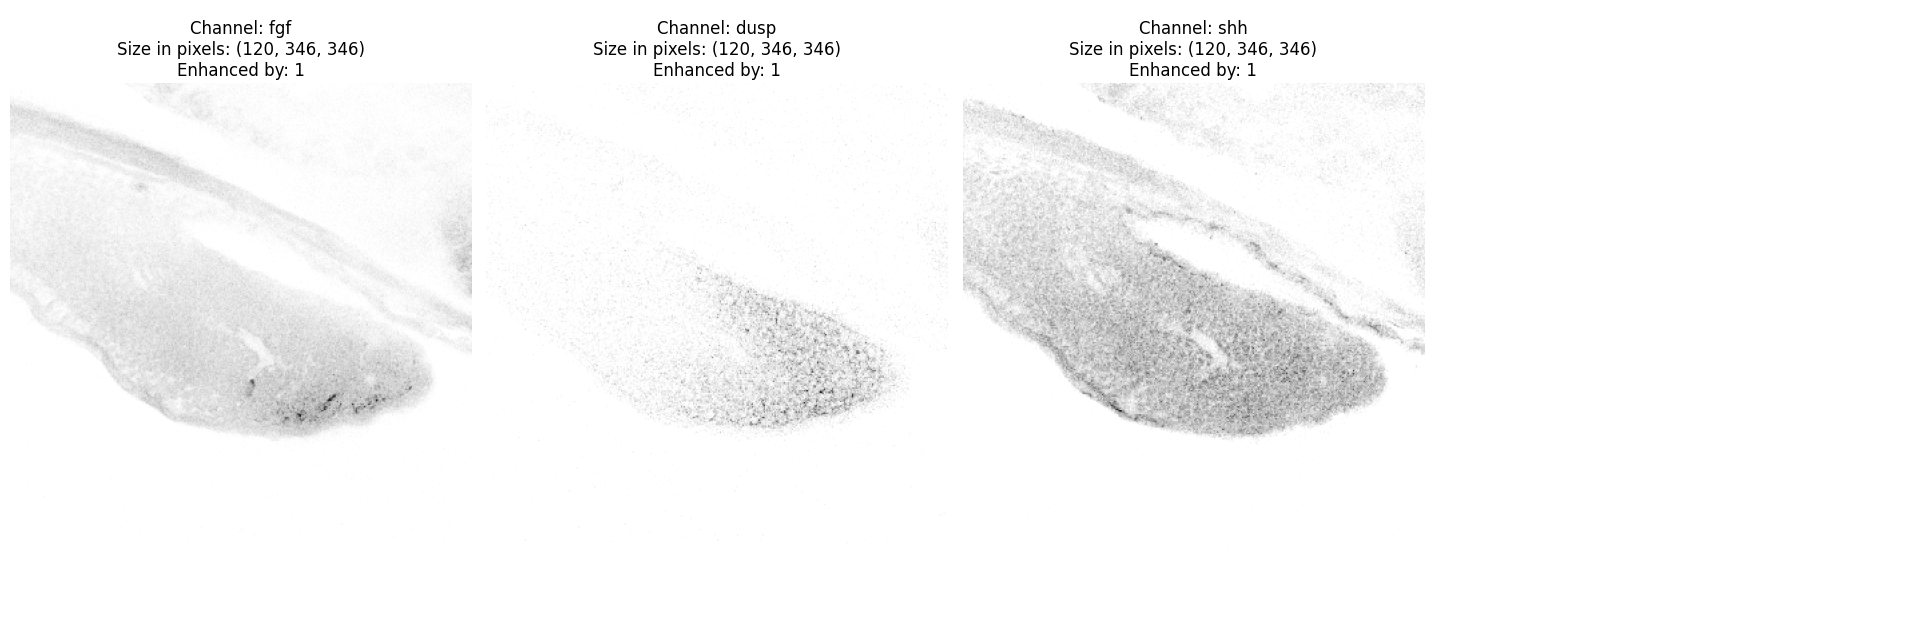

In [25]:
plot.preview(img, 0.5, 1, False, 'none')

# (Rotate) and Crop tissue

In [26]:
for key in img.keys():
    img[key] = img[key][:, 110:, 110:]

## Tissue mask

### <span style='color:Red'> [Manual input]  </span>  Tissue mask name

In [27]:
# make mask name
print('tissue mask name:')
#mask_segmeter_path = 'tissue_mask_' + sample + '.cl'
mask_segmeter_path = 'tissue_mask_lb28_fr.cl'
print(mask_segmeter_path)

tissue mask name:
tissue_mask_lb28_fr.cl


### <span style='color:Red'> [Manual input]  </span> segment tissue
### brown - outside; blue - line along inside border, brush size - 10 for both

In [28]:
img['tissue_mask'] = tifffile.imread('tissue_mask_lb28_fr.tif')[:, :, 110:]

In [29]:
img['tissue_mask'] = mask.largest_component(img['tissue_mask'])

In [30]:
@widgets.interact(z_position = (0, 0.9, 0.1))

def preview_images_z(z_position=0.5):
    z = int(z_position * img['tissue_mask'].shape[0])
    plt.imshow( img['tissue_mask'][ z, :, :], cmap='binary')

interactive(children=(FloatSlider(value=0.5, description='z_position', max=0.9), Output()), _dom_classes=('wid…

# Epidermis mask

In [31]:
img['epidermis_mask'] = mask.epiderm(img['tissue_mask'], 8, extend_along_z=True)

## Crop only tissue

In [32]:
img = mask.crop( img, img['epidermis_mask'] )

Dictionary with 3D data


## Substruct background

In [33]:
import copy
img['tissue_mask_with_epi'] = copy.deepcopy(img['tissue_mask'])
img['tissue_mask']          = img['tissue_mask'] * mask.invert(img['epidermis_mask'])

In [34]:
for key in img.keys():
    if key.find('mask') < 0:
        img[key] = mask.subtract_bg_clip(img[key], img['tissue_mask'], img['tissue_mask_with_epi'])

Masks for clipping and background subtraction are different.
Mean background value = 5.820014842944301
Masks for clipping and background subtraction are different.
Mean background value = 1.682402602083108
Masks for clipping and background subtraction are different.
Mean background value = 2.5371103803639308


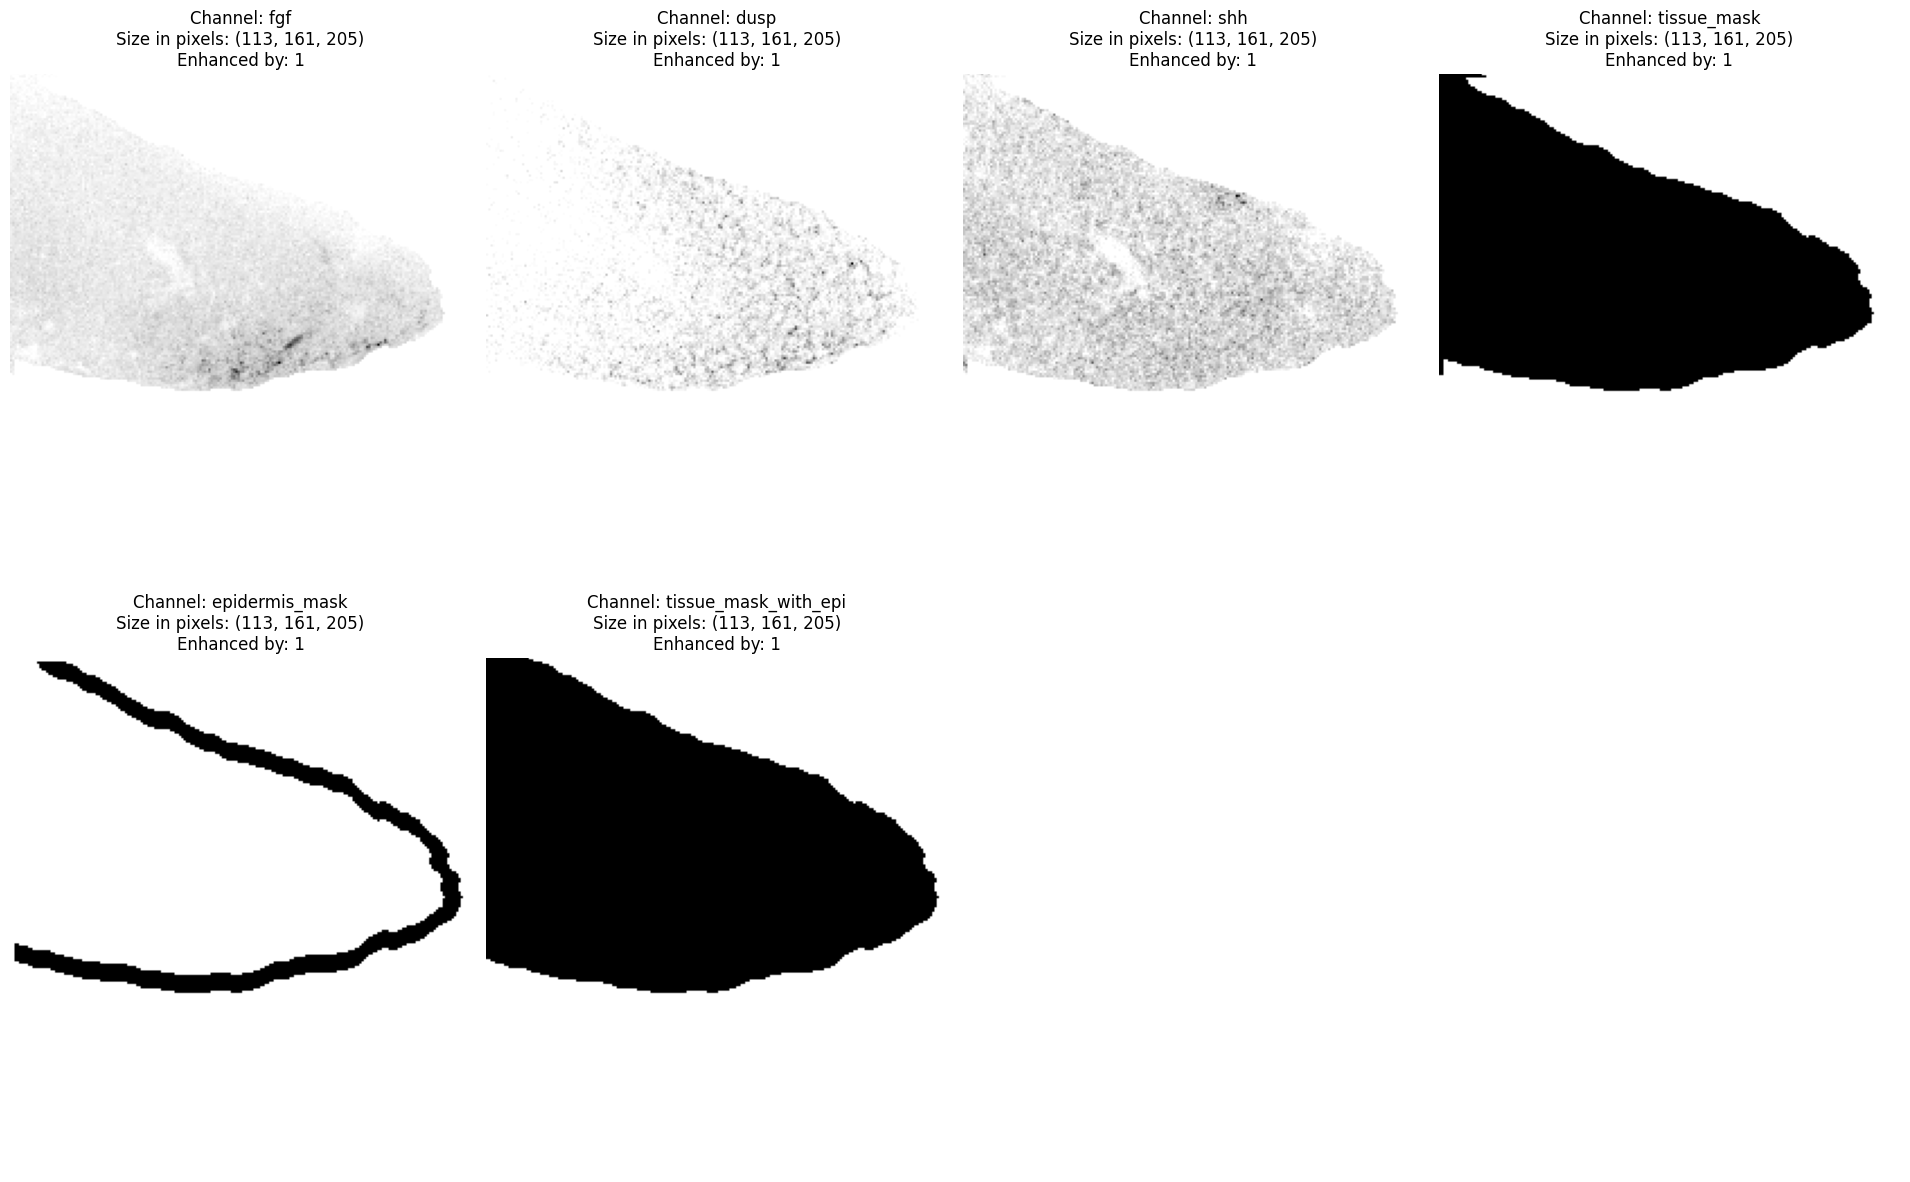

In [35]:
plot.preview(img, 0.5, 1, False, 'none')

# Segment Shh

In [36]:
ch_name = 'shh'

In [37]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

Relative dynamic range, (max - min)/max = 0.859343934318759


In [38]:
for pc in [40, 60, 70, 80]:
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * (image_filtered > pc * 0.01).astype(np.uint16)

In [39]:
img[ch_name+'50_mask'] = (image_filtered > 0.5).astype(np.uint16)
img[ch_name+'50_clip'] = img[ch_name] * img[ch_name+'50_mask']

# Segment Fgf8

In [40]:
ch_name = 'fgf'

In [41]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

Relative dynamic range, (max - min)/max = 0.8575470513283462


In [42]:
for pc in [40, 60, 70, 80]:
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * (image_filtered > pc * 0.01).astype(np.uint16)

In [43]:
img[ch_name+'50_mask'] = (image_filtered > 0.5).astype(np.uint16)
img[ch_name+'50_clip'] = img[ch_name] * img[ch_name+'50_mask']

# Segment Dusp

In [44]:
ch_name = 'dusp'

In [45]:
image_filtered = mask.gfilter( img[ch_name], sigma )
image_filtered = mask.minmaxnorm( image_filtered )

Relative dynamic range, (max - min)/max = 0.6975146258048575


In [46]:
for pc in [40, 60, 70, 80]:
    img[ch_name + str(pc) + '_clip'] = img[ch_name] * (image_filtered > pc * 0.01).astype(np.uint16)

In [47]:
img[ch_name+'50_mask'] = (image_filtered > 0.5).astype(np.uint16)
img[ch_name+'50_clip'] = img[ch_name] * img[ch_name+'50_mask']

In [48]:
img[ch_name+'30_mask'] = (image_filtered > 0.3).astype(np.uint16)
img[ch_name+'30_clip'] = img[ch_name] * img[ch_name+'30_mask']

In [49]:
img[ch_name+'20_mask'] = (image_filtered > 0.2).astype(np.uint16)
img[ch_name+'20_clip'] = img[ch_name] * img[ch_name+'20_mask']

# Flip and rotate

In [50]:
img = roi.rotate( img, 0, 0, 90 )

Dictionary with 3D data


In [51]:
for key in img.keys():
    img[key] = np.flip( img[key], 2)

## Save preprocessed image

In [52]:
img_arr = np.array( [img[key] for key in img.keys()] )
img_arr_keys = np.array( [key for key in img.keys()] )

In [53]:
folder_to_save = r'/home/natalia/Documents/github_image_analysis/experimental_data/treatment_all/'

In [54]:
file_to_save = f'hcr11_{sample}'
file_to_save

'hcr11_lb28_fl'

In [55]:
path_to_save = os.path.join(folder_to_save, file_to_save)

In [56]:
line_to_add = f'{img_path}   {path_to_save}'

info_file_path = os.path.join(folder_to_save, 'original_file_path_pretreated_file_path.txt')

if not os.path.isfile(info_file_path):
    # Create the file if it doesn't exist
    with open(info_file_path, 'w') as file:
        file.write(line_to_add + '\n')
else:
    # Append the line if the file already exists
    with open(info_file_path, 'a') as file:
        file.write(line_to_add + '\n')

In [57]:
np.save( path_to_save, img_arr)

In [58]:
np.save( path_to_save.split('.')[0] + '_keys.npy', img_arr_keys )

In [59]:
np.save( path_to_save.split('.')[0] + '_pixel.npy', pixel_size )